# Imports 

In [2]:
import librosa  # Importing required library
import numpy as np  # Importing required library
import os  # Importing required library
import pandas as pd  # Importing required library
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder  # Importing specific functions or classes
from sklearn.model_selection import train_test_split  # Importing specific functions or classes
import keras  # Importing required library
from keras.models import Sequential  # Importing specific functions or classes
from tensorflow.keras.layers import Dense, LSTM, Dropout  # Importing specific functions or classes
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout  # Importing specific functions or classes
import matplotlib.pyplot as plt  # Importing required library
import IPython.display as ipd  # Importing required library
from glob import glob  # Importing specific functions or classes
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
from IPython.display import Audio  # Importing specific functions or classes


## Optional Reading

Some of the most common feature extraction methods used in audio processing that we are going to use:

### MFCC (Mel-frequency cepstral coefficients):

- MFCCs are one of the most widely used feature extraction techniques in audio signal processing, particularly for speech recognition tasks.
- They capture the spectral envelope of an audio signal.
- The process involves applying the discrete cosine transform (DCT) to the log power spectrum of the audio signal.
- MFCCs are effective in capturing the characteristics of human speech due to their ability to approximate the human auditory system's response to sound frequencies.

### Mel Spectrogram:

- The Mel spectrogram is a visual representation of the power spectrum of an audio signal, where the frequencies are converted to the Mel scale.
- It divides the frequency spectrum into Mel-frequency bands, which are spaced according to human perception of sound.
- Mel spectrograms provide a compact representation of the frequency content of an audio signal and are often used as input for machine learning models in tasks such as music genre classification and audio event detection.

### Chroma Features:

- Chroma features capture the pitch content of an audio signal by representing the distribution of energy across different pitch classes (e.g., musical notes).
- They are useful for tasks involving harmonic analysis and music similarity.
- Chroma features are invariant to changes in timbre and loudness, making them suitable for tasks such as music genre classification and chord recognition.

### Spectral Contrast:

- Spectral contrast measures the difference in energy between peaks and valleys in the frequency spectrum of an audio signal.
- It provides information about the spectral texture or timbre of the audio signal.
- Spectral contrast features are useful for tasks such as music genre classification, audio fingerprinting, and sound texture analysis.
ound texture analysis.

# Exploration & Visualization

In [6]:
# Load audio file and extract chroma features
audio_files = glob(r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets\*\*.wav')


In [7]:
ipd.Audio(audio_files[0])

In [8]:
y, sr = librosa.load(audio_files[0])  # Using librosa for audio processing and feature extraction
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.00033982 -0.00072839 -0.00090695 -0.00124933 -0.00158278 -0.0019285
 -0.0021079  -0.00201866 -0.00160286 -0.00113702]
shape y: (10968,)
sr: 22050


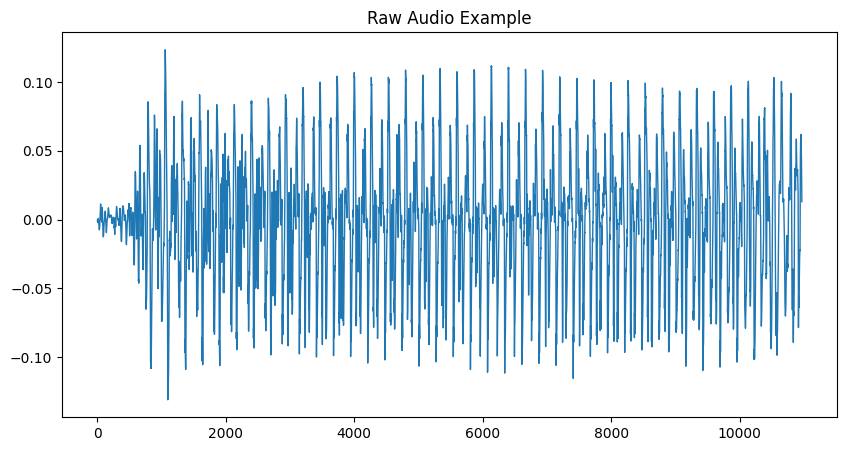

In [9]:
pd.Series(y).plot(figsize=(10, 5),  # Visualizing data or results
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

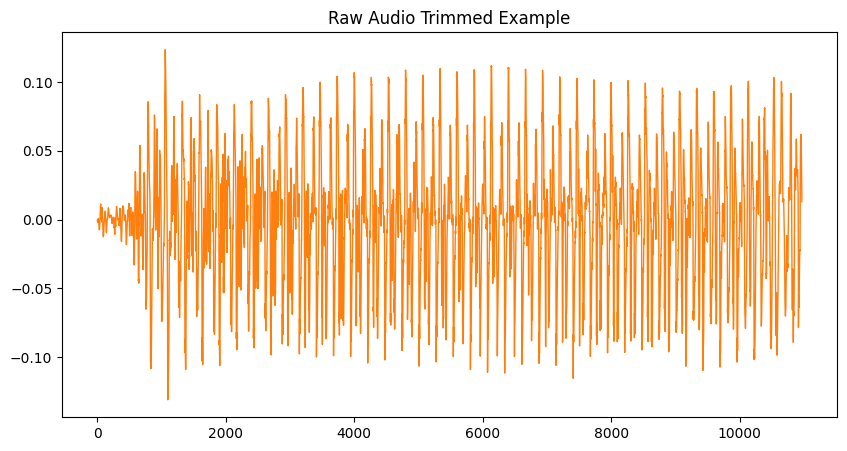

In [10]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)  # Using librosa for audio processing and feature extraction
pd.Series(y_trimmed).plot(figsize=(10, 5),  # Visualizing data or results
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

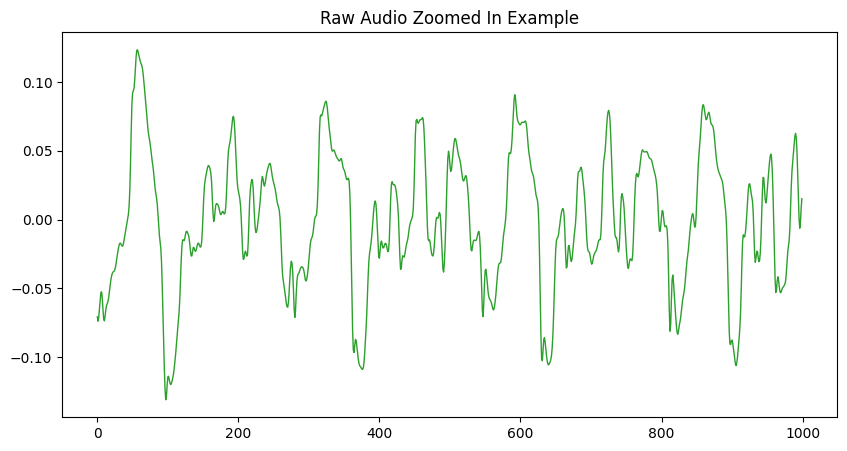

In [11]:
pd.Series(y[1000:2000]).plot(figsize=(10, 5),  # Visualizing data or results
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

## Visualizing the features extraction methods: 

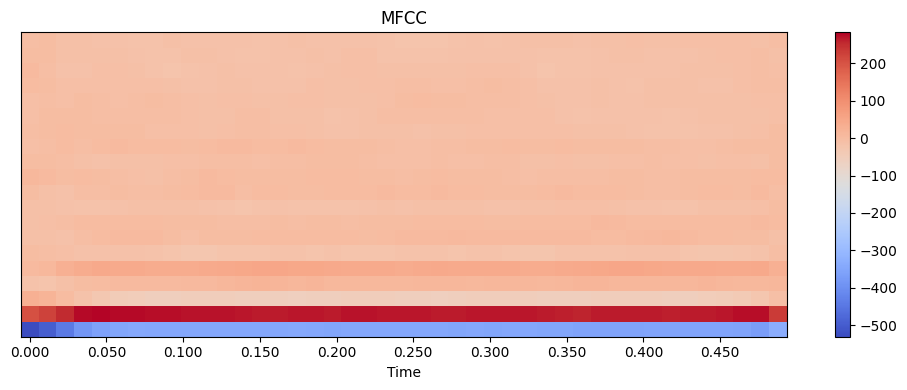

In [13]:
file_path = audio_files[0]
audio, sr = librosa.load(file_path, sr=None)  # Using librosa for audio processing and feature extraction

mfccs = librosa.feature.mfcc(y=audio, sr=sr)  # Using librosa for audio processing and feature extraction
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')  # Using librosa for audio processing and feature extraction
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

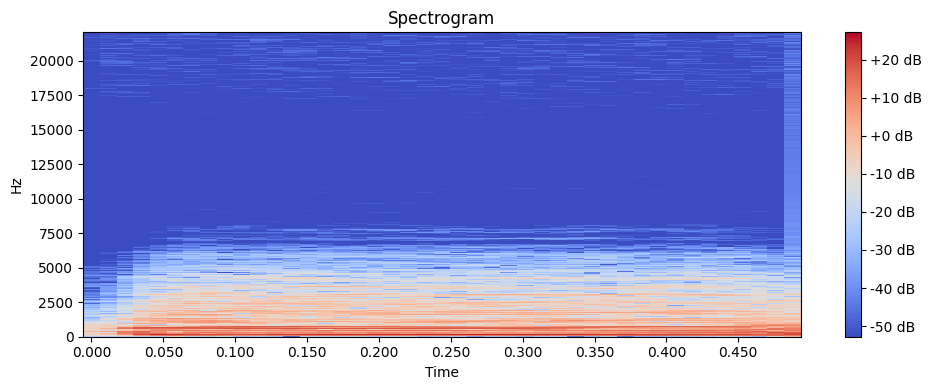

In [14]:
spectrogram = librosa.stft(audio)  # Using librosa for audio processing and feature extraction

spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))  # Using librosa for audio processing and feature extraction

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',fmax=8000)  # Using librosa for audio processing and feature extraction
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

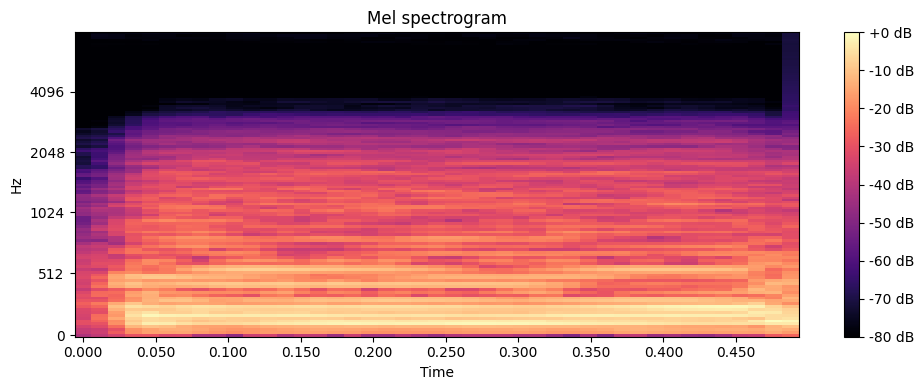

In [15]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)  # Using librosa for audio processing and feature extraction
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sr, y_axis='mel', fmax=8000, x_axis='time')  # Using librosa for audio processing and feature extraction
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

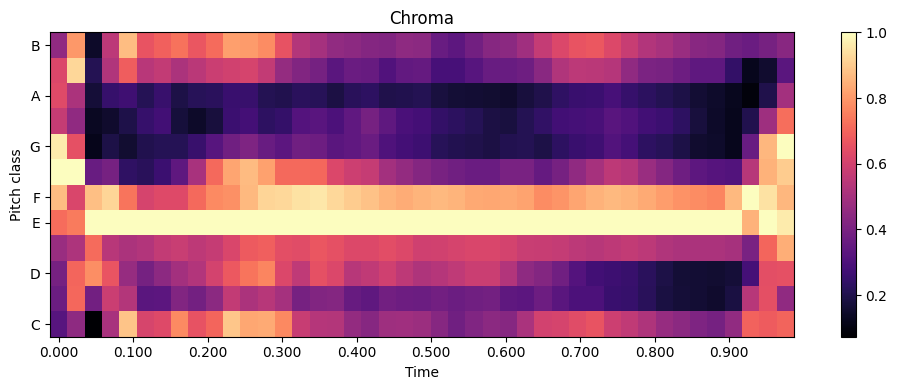

In [16]:
chroma = librosa.feature.chroma_stft(y=audio, sr=sr)  # Using librosa for audio processing and feature extraction
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')  # Using librosa for audio processing and feature extraction
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

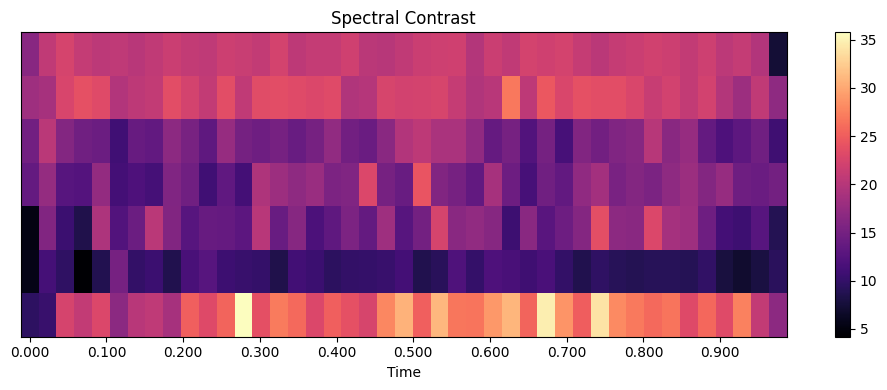

In [17]:
contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)  # Using librosa for audio processing and feature extraction
plt.figure(figsize=(10, 4))
librosa.display.specshow(contrast, x_axis='time')  # Using librosa for audio processing and feature extraction
plt.colorbar()
plt.title('Spectral Contrast')
plt.tight_layout()
plt.show()

# Data Augmentation 

## Data Augmentation

Data augmentation enhances the diversity of training data by applying transformations. These techniques are valuable for audio tasks, improving model robustness and performance.

### Techniques:

1. **Add White Noise**: Introduce random noise to simulate real-world environments.

2. **Time Stretch**: Adjust duration without pitch alteration.

3. **Time Shift**: Vary timing for temporal robustness.

4. **Pitch Shift**: Simulate pitch changes for musical note variation.


In [20]:
def add_white_noise(data, noise_level=0.005):
    max_amplitude = np.max(np.abs(data))
    noise_amp = noise_level * max_amplitude
    white_noise = noise_amp * np.random.normal(size=len(data))
    noisy_data = data + white_noise
    
    return noisy_data


def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)  # Using librosa for audio processing and feature extraction


def time_shift(data, max_shift_ms=50):
    shift_range = int(np.random.uniform(low=-max_shift_ms, high=max_shift_ms) * 1000)
    return np.roll(data, shift_range)


def random_pitch_shift(data, sr, pitch_range=(-2, 2)):
    pitch_shift_semitones = np.random.uniform(*pitch_range)
    pitch_factor = 2 ** (pitch_shift_semitones / 12.0)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)  # Using librosa for audio processing and feature extraction


## Original audio

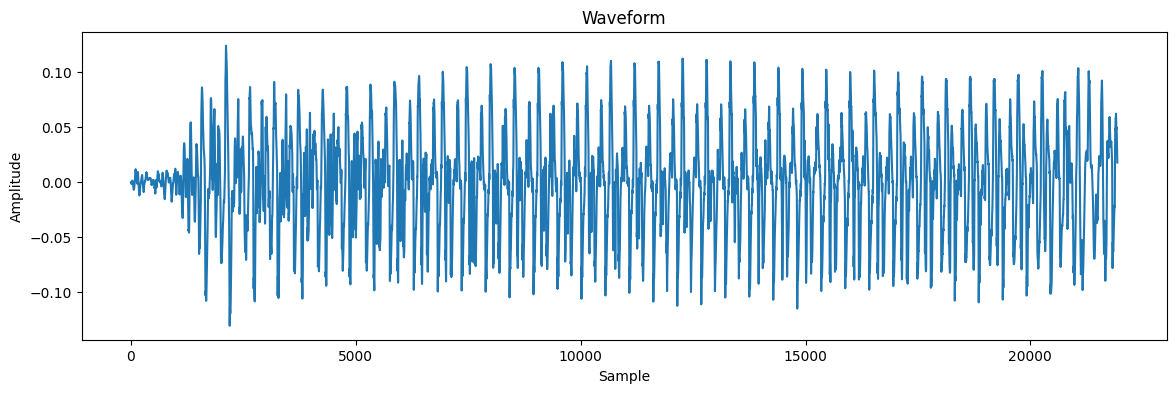

In [22]:
plt.figure(figsize=(14, 4))
plt.plot(audio)  # Visualizing data or results
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Audio(audio,rate=sr)

## Adding noise 

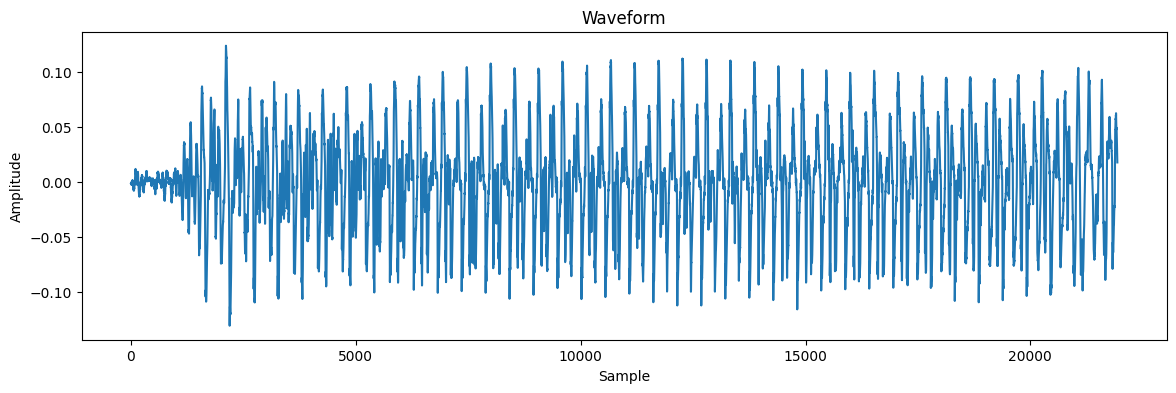

In [24]:
x = add_white_noise(audio)
plt.figure(figsize=(14, 4))
plt.plot(x)  # Visualizing data or results
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sr)

## Adding time stretch 

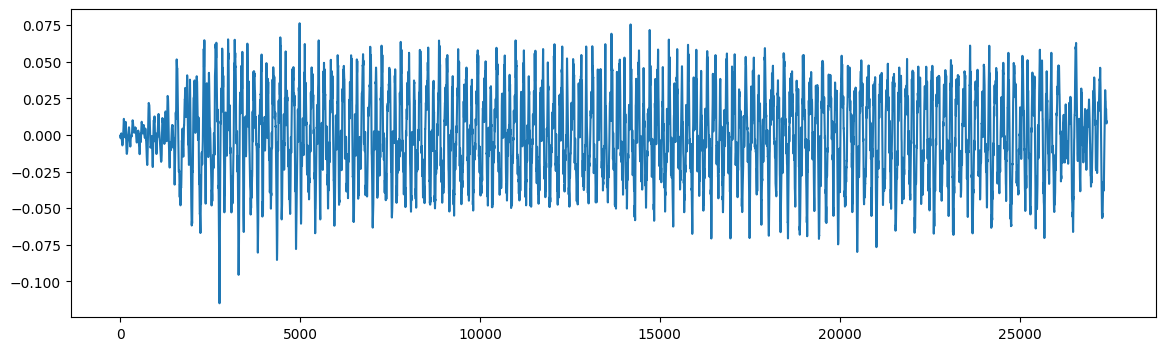

In [26]:
x = time_stretch(audio, rate=0.8)
plt.figure(figsize=(14, 4))
plt.plot(x)  # Visualizing data or results
plt.show()


Audio(x, rate=sr)

## Adding pitch shift 

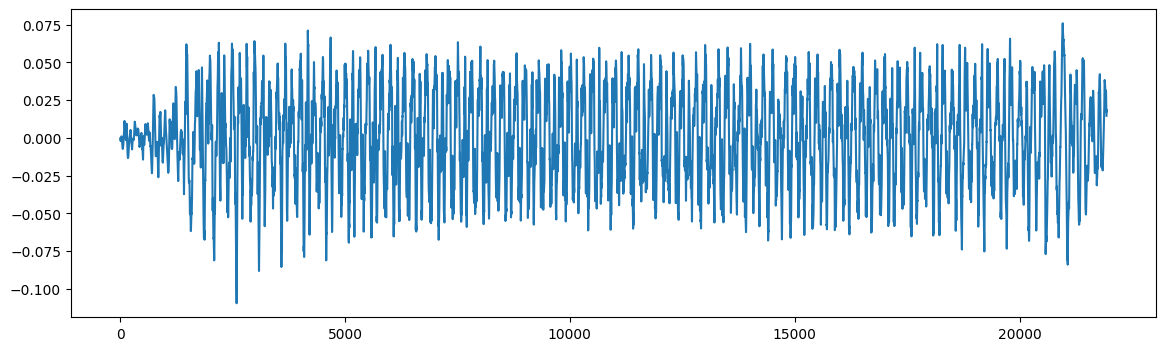

In [28]:
x = random_pitch_shift(audio, sr)
plt.figure(figsize=(14, 4))
plt.plot(x)  # Visualizing data or results
plt.show()
Audio(x, rate=sr)

# Preprocessing & Feature Extraction  

First, we need to define feature extraction function. We will use `MFCC`, `Mel Spectogram`,`Chroma` and `Spectral` features.

In [31]:
dataset_path = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets'

def extract_features(file_path, num_mfcc=13, n_fft=2048, hop_length=512, mfcc_len=100):
    audio, sr = librosa.load(file_path, sr=None)  # Using librosa for audio processing and feature extraction
    
    audio = add_white_noise(audio)
    audio = time_stretch(audio)
    audio = time_shift(audio)
    audio = random_pitch_shift(audio, sr)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)  # Using librosa for audio processing and feature extraction

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)  # Using librosa for audio processing and feature extraction
    
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)  # Using librosa for audio processing and feature extraction
    
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)  # Using librosa for audio processing and feature extraction
    
    if mfccs.shape[1] < mfcc_len:
        mfccs = np.pad(mfccs, ((0, 0), (0, mfcc_len - mfccs.shape[1])), mode='constant')
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, mfcc_len - mel_spectrogram.shape[1])), mode='constant')
        chroma = np.pad(chroma, ((0, 0), (0, mfcc_len - chroma.shape[1])), mode='constant')
        contrast = np.pad(contrast, ((0, 0), (0, mfcc_len - contrast.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :mfcc_len]
        mel_spectrogram = mel_spectrogram[:, :mfcc_len]
        chroma = chroma[:, :mfcc_len]
        contrast = contrast[:, :mfcc_len]
    
    features = np.vstack((mfccs, mel_spectrogram, chroma, contrast))
    label = os.path.basename(os.path.dirname(file_path)).split('. ')[1]
    
    return features, label


# Function to process the entire dataset
def process_dataset(dataset_path, mfcc_len=100):
    data = []
    labels = []
    # Iterate through each audio file
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                # Extract MFCC features and label
                features, label = extract_features(file_path, mfcc_len=mfcc_len)
                data.append(features)
                labels.append(label)
    return data, labels

data, labels = process_dataset(dataset_path)

C:\Users\CJHx6\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Converting the data from a list of arrays to a numpy array and flattening it, so that we can create a dataframe for the data.

In [33]:
data = np.array(data)
data_flat = np.array([d.flatten() for d in data])

df = pd.DataFrame(data_flat)
df['label'] = labels
df = df.sample(frac=1).reset_index(drop=True)

In [34]:
df

,0,1,2,3,4,5,6,7,8,9,...,15991,15992,15993,15994,15995,15996,15997,15998,15999,label
0,-363.027336,-406.593453,-528.919439,-535.416910,-537.872041,-539.847436,-536.751620,-535.315115,-537.820309,-540.851862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A-sharp 2
1,-235.146793,-263.505607,-312.735266,-309.250177,-296.526879,-296.572352,-304.931768,-321.017763,-346.801017,-353.714746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A2
2,-368.748551,-354.715291,-381.867404,-393.499802,-395.570203,-397.664649,-403.341855,-410.013920,-411.228602,-408.314811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C
3,-230.285724,-272.711511,-367.992007,-384.287093,-389.224012,-391.604853,-394.699491,-398.878467,-403.704016,-404.987667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1
4,-291.681769,-319.620706,-381.775358,-382.986673,-377.957519,-376.425457,-382.951402,-404.591248,-426.455780,-442.867569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,-406.800714,-403.393610,-434.499608,-452.281690,-459.349432,-456.181222,-453.126307,-454.231302,-457.389640,-455.306605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D
2266,-303.445654,-352.474398,-458.399812,-474.847528,-478.021718,-479.214414,-480.231527,-479.571394,-481.350116,-481.227576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
2267,-287.466885,-310.595153,-367.299567,-377.058459,-380.513273,-384.043987,-383.945023,-386.531628,-387.776386,-387.714588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F-sharp 1
2268,-466.768739,-482.440701,-540.976419,-552.068314,-549.232904,-552.695037,-556.368122,-556.415893,-553.455894,-551.977473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D-sharp 1


# Splitting our data & Encoding the label

In [36]:
X = df.iloc[: ,:-1].values
Y = df['label'].values

In [37]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()  # Training the model with data

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)  # Training the model with data

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.7, random_state=42, shuffle=True)  # Training the model with data

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape  # Training the model with data


((1816, 16000), (1816, 37), (318, 16000), (318, 37), (136, 16000), (136, 37))

Applying `StandardScaler` to normalize our data. This means that the mean of each feature becomes zero, and the variance becomes one.

In [40]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)  # Training the model with data
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

Expanding the dimensions of the data so it is suitable for the neural network.

In [42]:
x_train = np.expand_dims(x_train, axis=-1)  # Add an extra dimension at the end  # Training the model with data
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

# Print the shapes to verify
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)  # Training the model with data


(1816, 16000, 1) (1816, 37) (318, 16000, 1) (318, 37) (136, 16000, 1) (136, 37)


# Modelling 

## CNN 

In [45]:
model = Sequential()  # Defining or interacting with the machine learning model
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(16000, 1)))  # Defining or interacting with the machine learning model
model.add(MaxPooling1D(pool_size=2))  # Defining or interacting with the machine learning model
model.add(Conv1D(128, kernel_size=3, activation='relu'))  # Defining or interacting with the machine learning model
model.add(MaxPooling1D(pool_size=2))  # Defining or interacting with the machine learning model
model.add(Conv1D(256, kernel_size=3, activation='relu'))  # Defining or interacting with the machine learning model
model.add(MaxPooling1D(pool_size=2))  # Defining or interacting with the machine learning model
model.add(Flatten())  # Defining or interacting with the machine learning model
model.add(Dense(256, activation='relu'))  # Defining or interacting with the machine learning model
model.add(Dropout(0.5))  # Defining or interacting with the machine learning model
model.add(Dense(128, activation='relu'))  # Defining or interacting with the machine learning model
model.add(Dropout(0.5))  # Defining or interacting with the machine learning model
model.add(Dense(37, activation='softmax'))  # Defining or interacting with the machine learning model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Defining or interacting with the machine learning model

history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val), verbose=1)  # Defining or interacting with the machine learning model

loss, accuracy = model.evaluate(x_val, y_val)  # Defining or interacting with the machine learning model

print(f'Validation Loss: {loss:.3f}')
print(f'Validation Accuracy: {accuracy:.3f}')


C:\Users\CJHx6\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.0426 - loss: 4.5718 - val_accuracy: 0.2279 - val_loss: 3.3800
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1656 - loss: 3.2450 - val_accuracy: 0.6029 - val_loss: 2.2373
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3514 - loss: 2.3999 - val_accuracy: 0.7721 - val_loss: 1.1926
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5229 - loss: 1.6896 - val_accuracy: 0.8529 - val_loss: 0.6559
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6376 - loss: 1.2801 - val_accuracy: 0.9265 - val_loss: 0.4234
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7021 - loss: 0.9721 - val_accuracy: 0.9338 - val_loss: 0.2382
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7692 - loss: 0.7201 - val_accuracy: 0.9559 - val_loss: 0.1951
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8071 - loss: 0.6279 - val_accuracy: 0.9559 - val_loss:

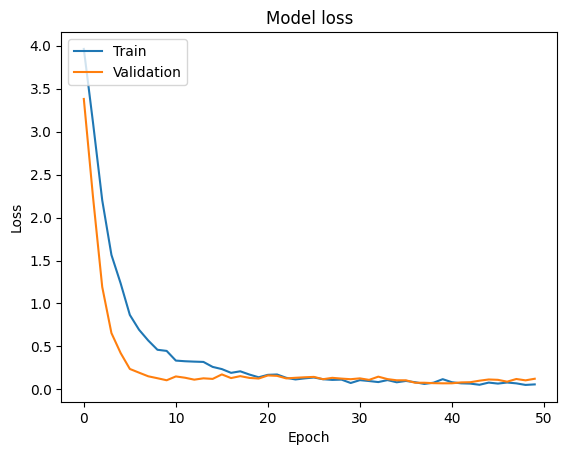

In [46]:
plt.plot(history.history['loss'])  # Visualizing data or results
plt.plot(history.history['val_loss'])  # Visualizing data or results
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
Test Accuracy: 0.965


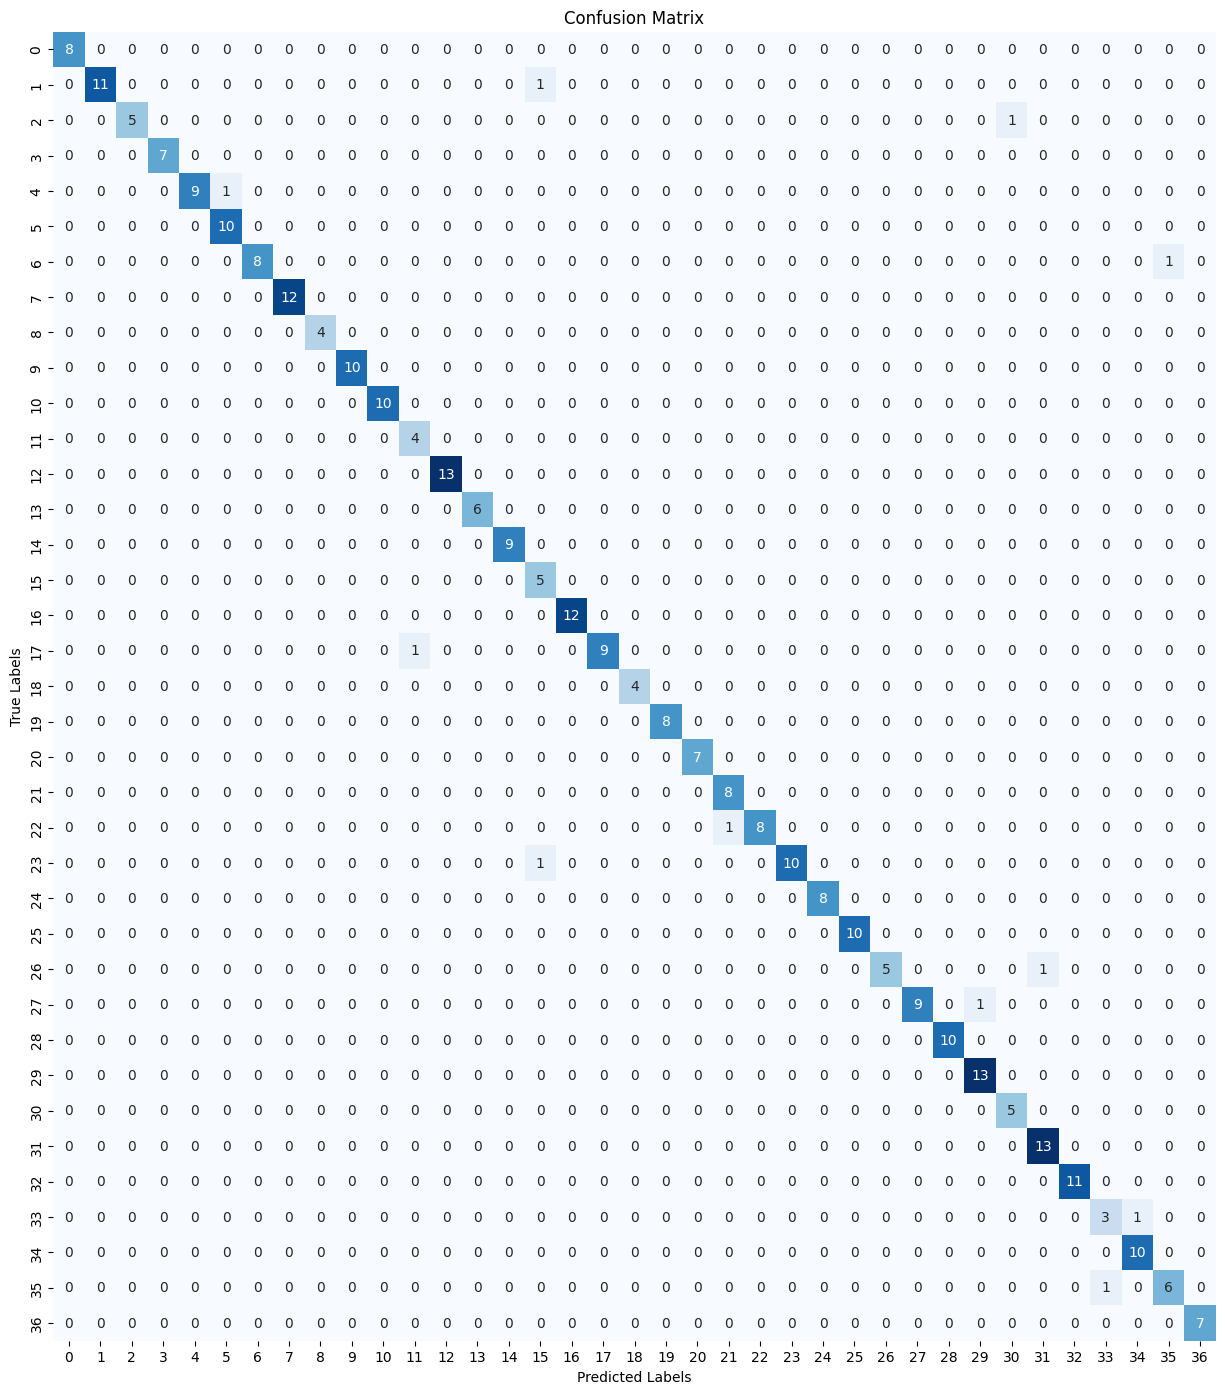

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix  # Importing specific functions or classes
import seaborn as sns  # Importing required library

predictions = model.predict(x_test)  # Defining or interacting with the machine learning model

predicted_labels = np.argmax(predictions, axis=1)  # Making predictions using the trained model

true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)  # Making predictions using the trained model
print(f'Test Accuracy: {accuracy:.3f}')

conf_matrix = confusion_matrix(true_labels, predicted_labels)  # Making predictions using the trained model
plt.figure(figsize=(15, 17))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


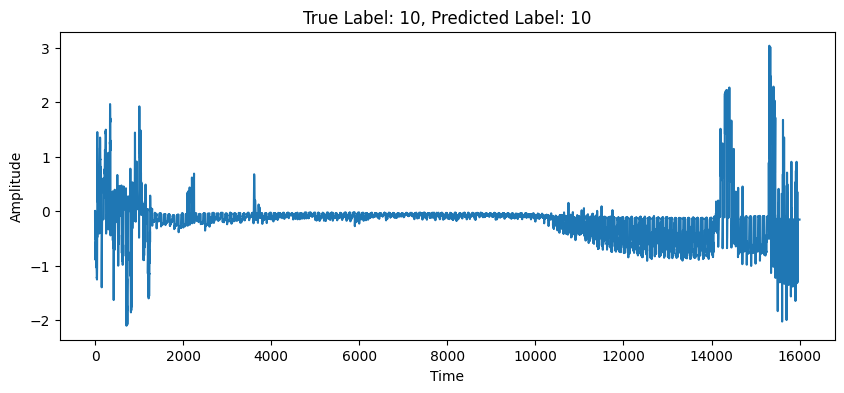

In [49]:
sample_index = 124 
sample = x_test[sample_index]
true_label = np.argmax(y_test[sample_index])

predicted_probs = model.predict(sample.reshape(1, -1, 1))[0]  # Defining or interacting with the machine learning model
predicted_label = np.argmax(predicted_probs)  # Making predictions using the trained model

plt.figure(figsize=(10, 4))
plt.plot(sample)  # Visualizing data or results
plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')  # Making predictions using the trained model
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

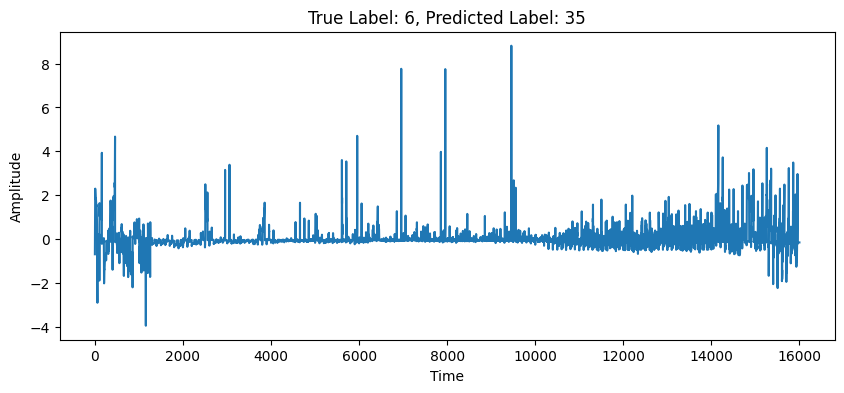

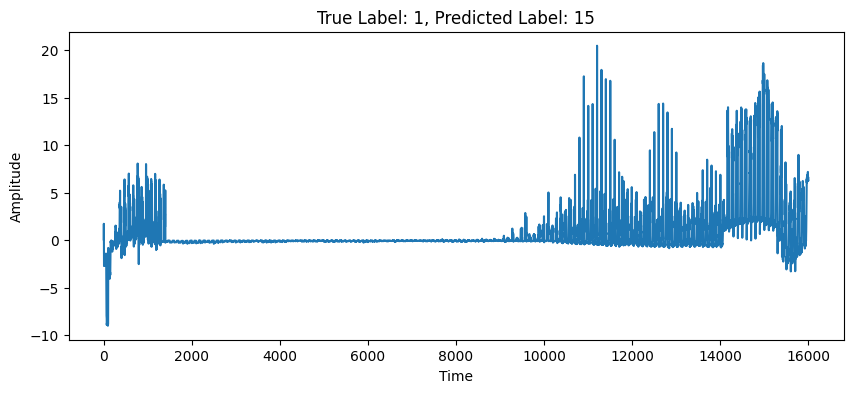

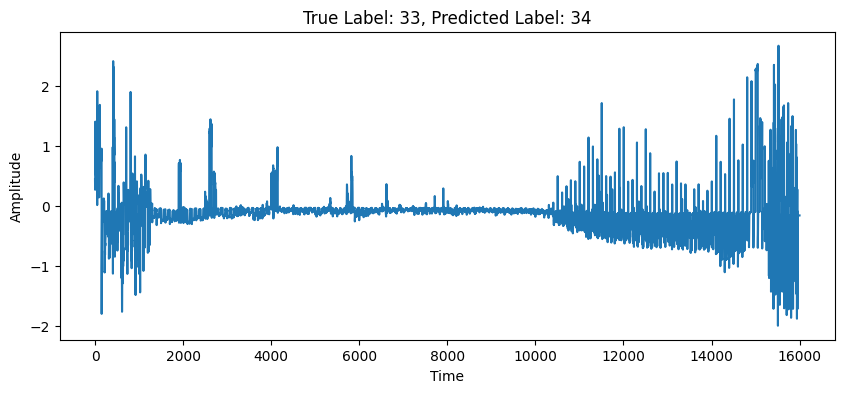

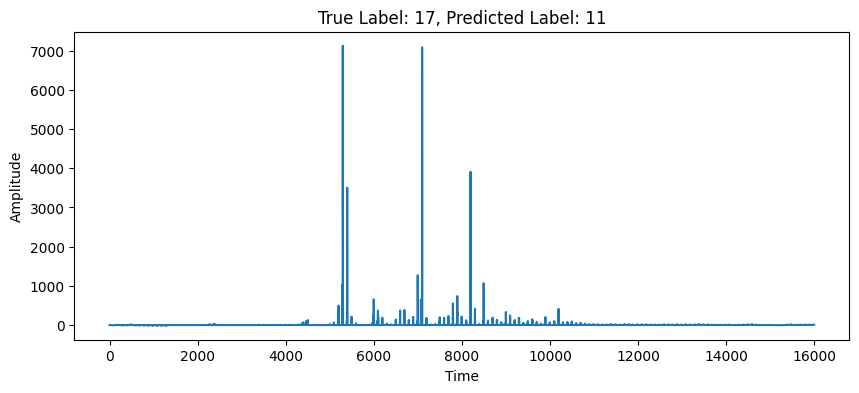

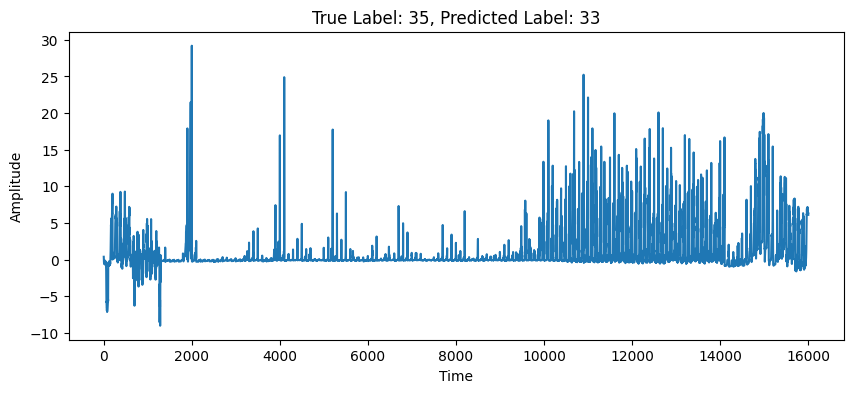

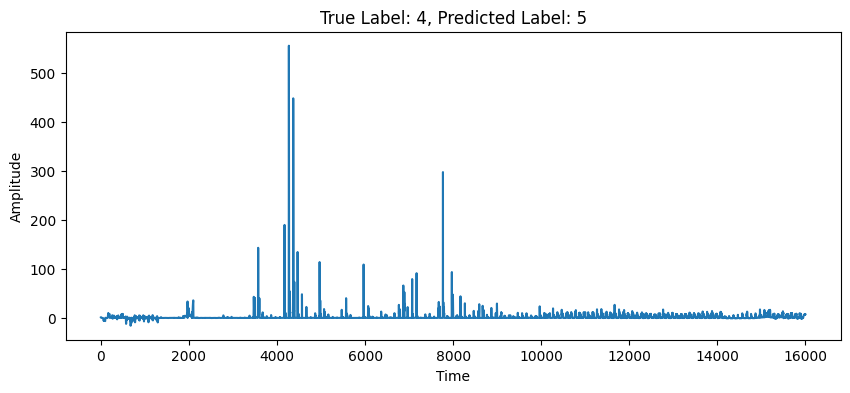

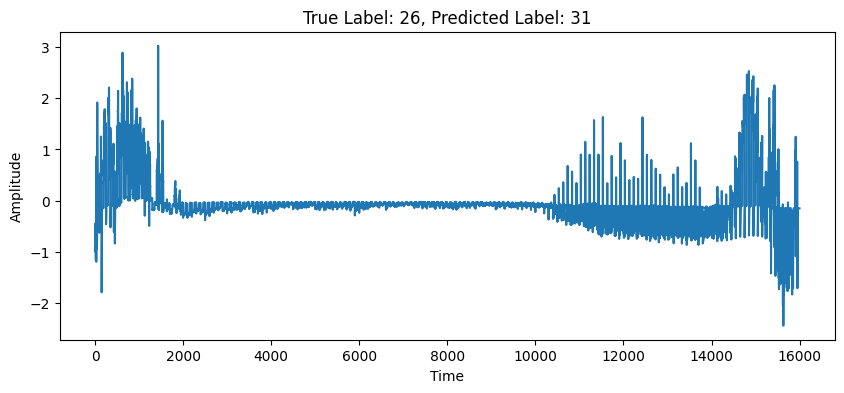

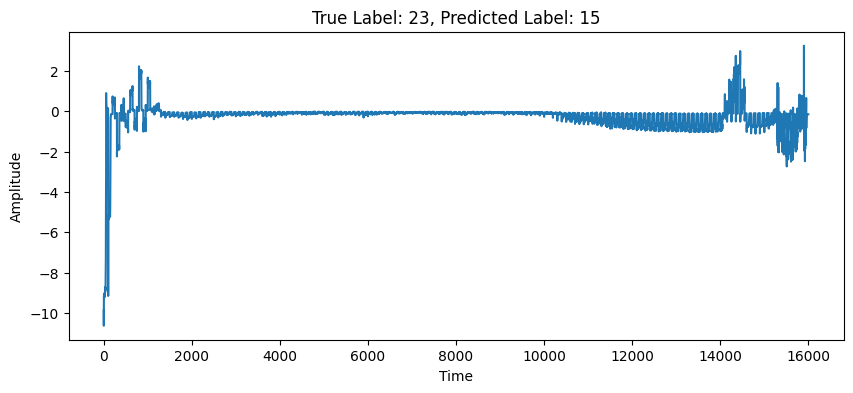

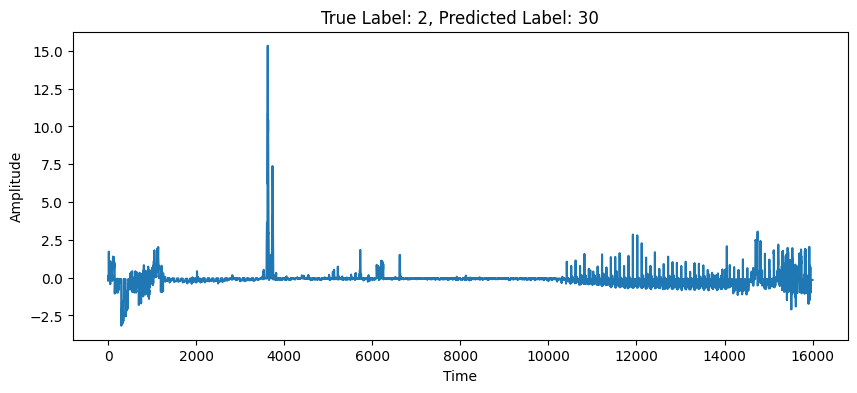

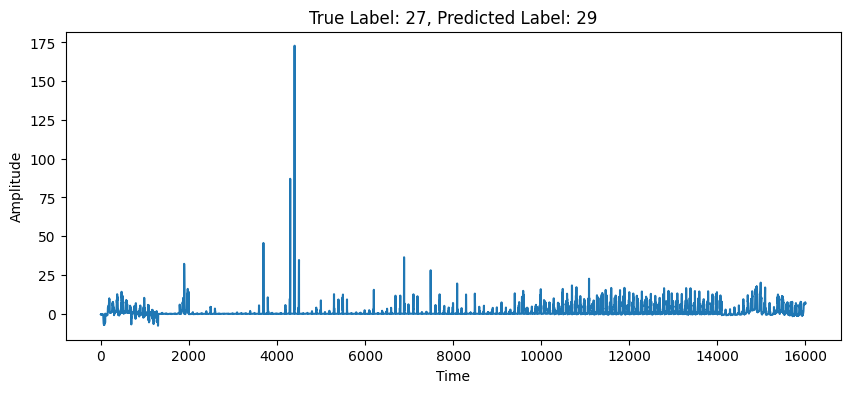

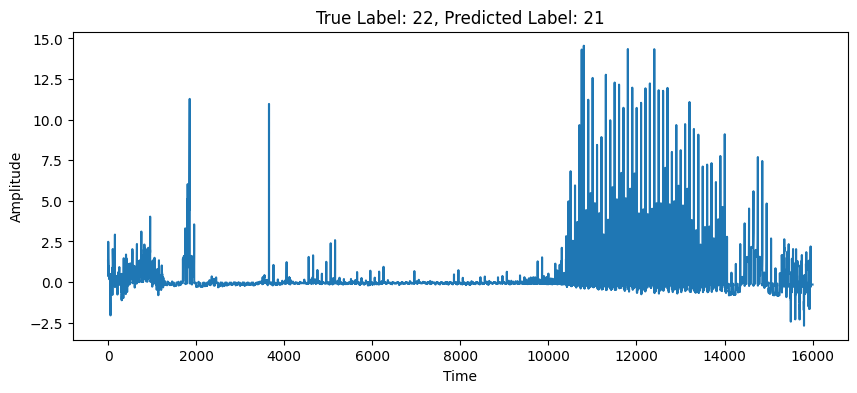

In [50]:
incorrect_indices = []
incorrect_predictions = []  # Making predictions using the trained model

for i in range(len(x_test)):
    sample = x_test[i]
    true_label = np.argmax(y_test[i])
    
    predicted_probs = model.predict(sample.reshape(1, -1, 1))[0]  # Defining or interacting with the machine learning model
    predicted_label = np.argmax(predicted_probs)  # Making predictions using the trained model
    
    if predicted_label != true_label:  # Making predictions using the trained model
        incorrect_indices.append(i)
        incorrect_predictions.append((sample, true_label, predicted_label))  # Making predictions using the trained model

for sample, true_label, predicted_label in incorrect_predictions:  # Making predictions using the trained model
    plt.figure(figsize=(10, 4))
    plt.plot(sample)  # Visualizing data or results
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')  # Making predictions using the trained model
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


In [51]:
from keras.models import Sequential  # Importing specific functions or classes
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization  # Importing specific functions or classes

model = Sequential([  # Defining or interacting with the machine learning model
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),  # Training the model with data
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(Y.shape[1], activation='softmax')  # Output layer for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Defining or interacting with the machine learning model
model.summary()  # Defining or interacting with the machine learning model


C:\Users\CJHx6\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 15998, 64)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 15998, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 7999, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7999, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 7999, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7999, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 37)                  │           1,221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,037 (593.89 KB)

 Trainable params: 151,909 (593.39 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history = model.fit(  # Defining or interacting with the machine learning model
    x_train, y_train,  # Training the model with data
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 585s 10s/step - accuracy: 0.0417 - loss: 3.6072 - val_accuracy: 0.0368 - val_loss: 3.5747
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 589s 10s/step - accuracy: 0.0527 - loss: 3.4759 - val_accuracy: 0.0735 - val_loss: 3.5509
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 597s 10s/step - accuracy: 0.0703 - loss: 3.3359 - val_accuracy: 0.0294 - val_loss: 3.4826
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 599s 11s/step - accuracy: 0.0897 - loss: 3.2606 - val_accuracy: 0.0368 - val_loss: 3.4947
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 599s 11s/step - accuracy: 0.0903 - loss: 3.1611 - val_accuracy: 0.0588 - val_loss: 3.4991
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 599s 11s/step - accuracy: 0.1267 - loss: 3.0273 - val_accuracy: 0.0809 - val_loss: 3.4386
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 604s 11s/step - accuracy: 0.1469 - loss: 2.9373 - val_accuracy: 0.0809 - val_loss: 3.6661
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 619s 11s/step - accuracy: 0.1193 - loss: 2.9116 - val_accuracy: 0.

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)  # Defining or interacting with the machine learning model
print(f"Test Accuracy: {test_accuracy:.2f}")


In [ ]:
model.save('audio_classification_model.h5')  # Defining or interacting with the machine learning model


In [ ]:
from keras.models import load_model  # Importing specific functions or classes
loaded_model = load_model('audio_classification_model.h5')  # Defining or interacting with the machine learning model
